# 5 | ARIMA Modeling
---
* [01 API Data Requests](01_API_pulls.ipynb)
* [02 Initial EDA](02_EDA.ipynb)
* [03 Prophet](03_prophet.ipynb)
* [04 Greykite](04_greykite.ipynb)
* [05 ARIMA](05_ARIMA.ipynb) 
---

> Modified from notebook by: Matt Brems, Joseph Nelson, Justin Pounders

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# defining stylesheet for all figures in notebook
plt.style.use('gstyle.mplstyle')

import warnings
warnings.filterwarnings('ignore')

In [4]:
df_in = pd.read_csv('../data/processed/bart.csv')
df_in.set_index(pd.DatetimeIndex(df_in['ds']), inplace = True)
df_in.drop(columns = ['ds'], inplace = True)

In [5]:
# df = df_in[:'2018-09-01']
# df = df_in['2010-01-01':]
df = df_in[:'2020-03-01']
# df = df_in
df.head()

,ridership
ds,
2000-01-01,1178324
2000-02-01,1178420
2000-03-01,1198004
2000-04-01,1220648
2000-05-01,1222712


In [6]:
# modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    plt.figure(figsize=(13,7))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

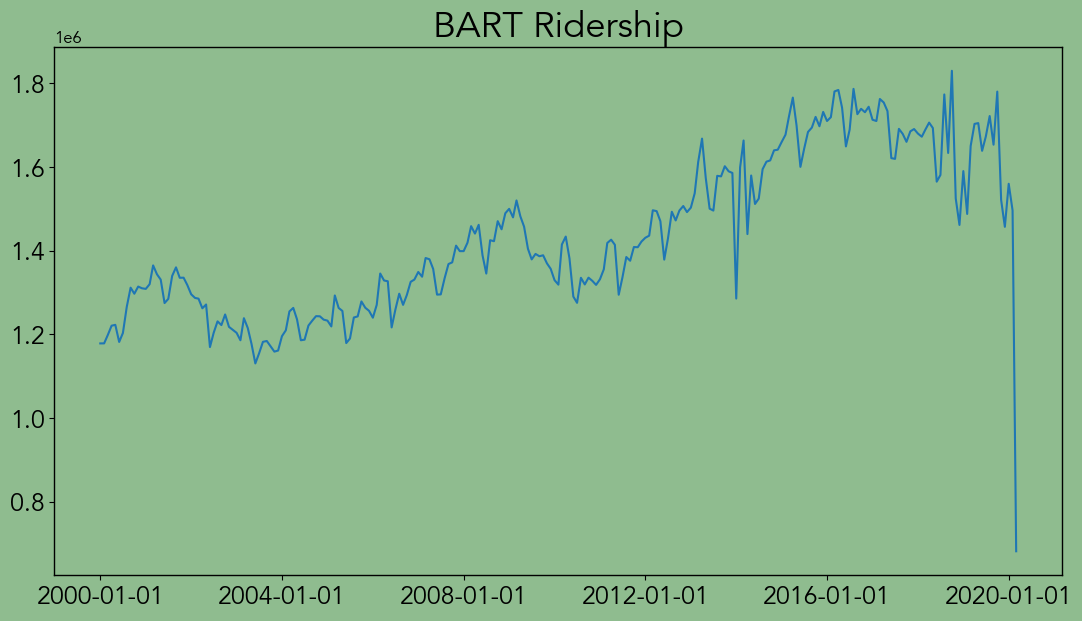

In [7]:
plot_series(df, cols = ['ridership'], title='BART Ridership', steps = 48)

> This show a `trend` and `seasonality`, NOT $stationary$, will need to difference to use `ARIMA`

> ## Checking for Stationarity with Augmented Dickey-Fuller Test

In [8]:
# Function to interpret stat written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput


# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['ridership']))

Test Statistic   -1.318407
p-value           0.620709
dtype: float64

With $p=0.81$, we cannot reject $H_0$, so we must difference.

In [9]:
# Create first and second order diffs
df['first_diff_ride'] = df['ridership'].diff(1)
df['second_diff_ride'] = df['ridership'].diff(1).diff(1)

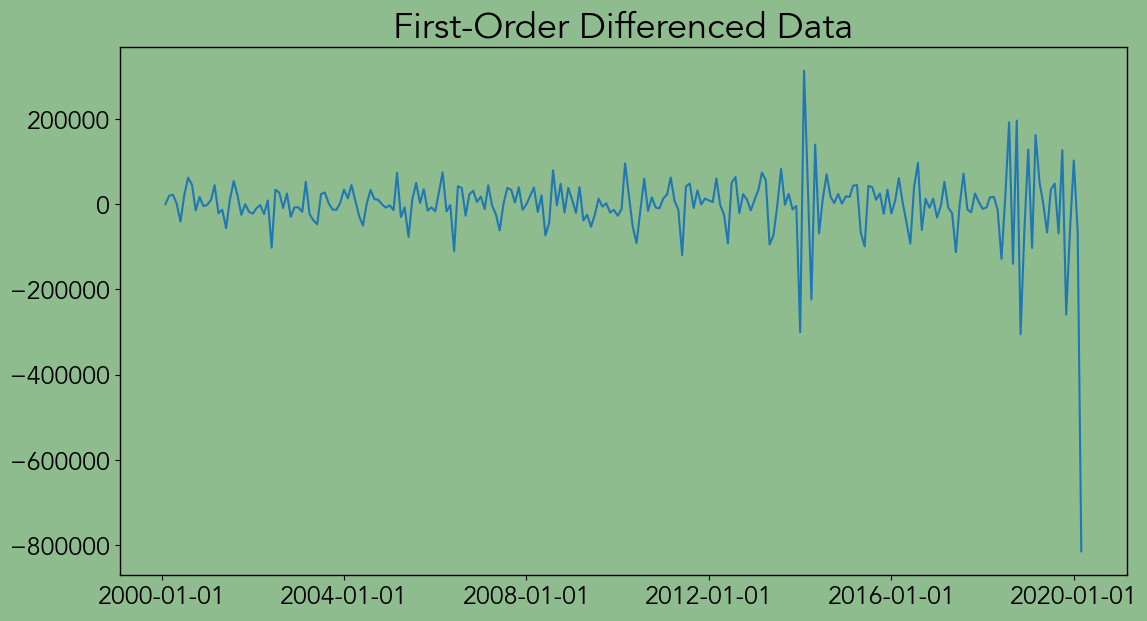

In [10]:
plot_series(df, ['first_diff_ride'], title = 'First-Order Differenced Data', steps = 48)

In [11]:
# ADF test on 1st-Order Differenced
interpret_dftest(adfuller(df['first_diff_ride'].dropna()))

Test Statistic   -1.640842
p-value           0.461821
dtype: float64

With $p < 0.05$, we reject $H_0$ and thus will model $Y'_t = Y_t - Y_{t-1}$ rather than $Y_t$.

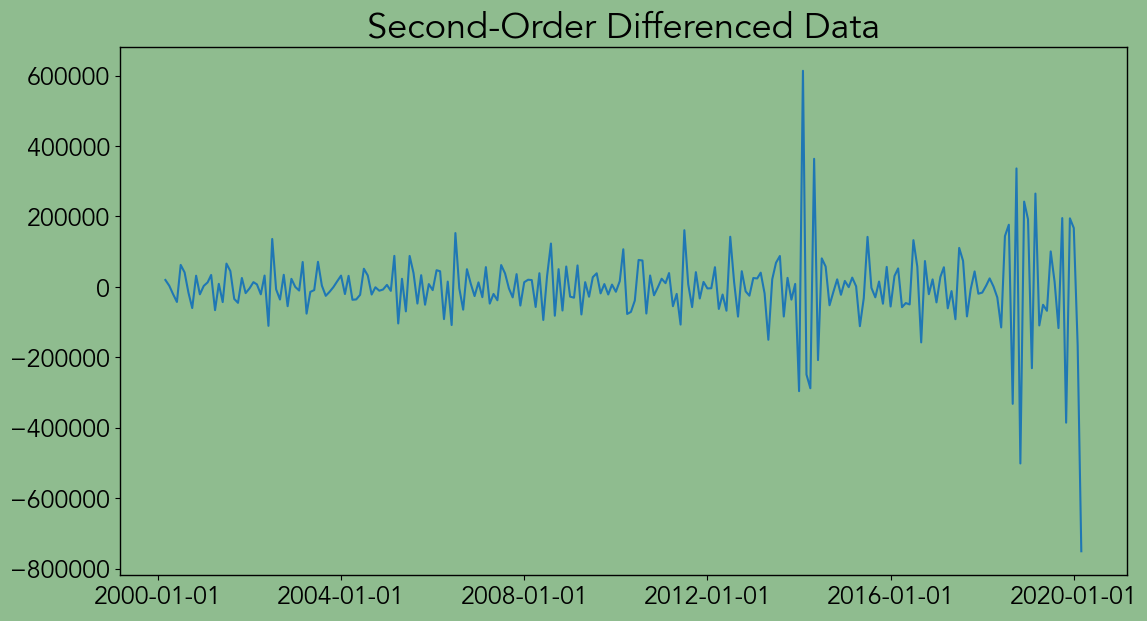

In [12]:
# plot 2nd differenced data 
plot_series(df, ['second_diff_ride'], 
           title = 'Second-Order Differenced Data', steps = 48)

In [13]:
# ADF test on 2nd-Order Differenced
interpret_dftest(adfuller(df['second_diff_ride'].dropna()))

Test Statistic   -4.359085
p-value           0.000350
dtype: float64

With $p < 0.05$ for $2^{nd}-order$ differences, we reject $H_0$ and can model with $Y''_t = Y'_t - Y'_{t-1} = Y_t - 2Y_{t-1} + Y_{t-2}$ as well.

>## Building ARIMA model

Specifying $ARIMA(p, d, q)$ model requires:
- $d$: differences calculated to acheive $stationarity$
- $p$: lags over which we regress $Y_t^{(d)}$
- $q$: errors over which we regress $Y_t^{(d)}$  

We'll determine $p$ and $q$ iterating over a manual GridSearch to find optimal values. 
<!-- | p | d | q |          Model         |
|:-:|:-:|:-:|:----------------------:|
| 1 | 0 | 0 |  ARIMA(1,0,0) = AR(1)  |
| 0 | 0 | 1 |  ARIMA(0,0,1) = MA(1)  |
| 1 | 0 | 1 | ARIMA(1,0,1) = ARMA(1,1) |
| 1 | 1 | 1 |      ARIMA(1,1,1)      |
| 1 | 1 | 0 |      ARIMA(1,1,0)      |
| 0 | 1 | 1 |      ARIMA(0,1,1)      |

_* table adapted from lecture notebook_ -->

<!-- Depending on our values of $p$, $d$, and $q$, we might refer to these models by slightly different names.

- If $d=0$ and $q=0$, an AR(p) model is specified by how many lags $p$ we regress $Y_t$ on.
- If $d=0$ and $p=0$, an MA(q) model is specified by how many errors $q$ we regress $Y_t$ on.
- If $d=0$, an ARMA(p, q) model is specified by how many lags $p$ and how many errors $q$ we regress $Y_t$ on. -->


In [14]:
# Create train-test split.
y_train, y_test = train_test_split(df['first_diff_ride'],
                                  test_size = 0.2,
                                  shuffle = False)

In [15]:
y_train.tail()

ds
2015-10-01    25536.0
2015-11-01   -22392.0
2015-12-01    34228.0
2016-01-01   -21608.0
2016-02-01     9132.0
Name: first_diff_ride, dtype: float64

In [16]:
y_test.head()

ds
2016-03-01    61412.0
2016-04-01     3620.0
2016-05-01   -42444.0
2016-06-01   -92452.0
2016-07-01    40120.0
Name: first_diff_ride, dtype: float64

In [17]:
# Grid Search Code adapted from in-class lesson
best_aic = 99 * (10**16)
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        # try & excpet statements 
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            # print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y_vag
                         order = (p, 1, q)); # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print(f'MODEL FINISHED: best parameters: (p = {best_p},1, q = {best_q}).')
print(f'AIC: {best_aic}.')

The AIC for ARIMA(0,1,0) is: 4893.000092067767
The AIC for ARIMA(0,1,1) is: 4741.259162282016
The AIC for ARIMA(0,1,2) is: 4714.106378964629
The AIC for ARIMA(0,1,3) is: 4700.139827777917
The AIC for ARIMA(0,1,4) is: 4698.494832473697
The AIC for ARIMA(1,1,0) is: 4841.946033006868
The AIC for ARIMA(1,1,1) is: 4737.142263335965
The AIC for ARIMA(1,1,2) is: 4731.347203171461
The AIC for ARIMA(1,1,3) is: 4696.776614388927
The AIC for ARIMA(1,1,4) is: 4699.445218179153
The AIC for ARIMA(2,1,0) is: 4792.8403093407305
The AIC for ARIMA(2,1,1) is: 4722.632507167384
The AIC for ARIMA(2,1,2) is: 4698.888822343484
The AIC for ARIMA(2,1,3) is: 4698.557953685974
The AIC for ARIMA(2,1,4) is: 4700.183648271754
The AIC for ARIMA(3,1,0) is: 4785.925091274546
The AIC for ARIMA(3,1,1) is: 4723.511268086069
The AIC for ARIMA(3,1,2) is: 4707.729162579912
The AIC for ARIMA(3,1,3) is: 4700.252345589213
The AIC for ARIMA(3,1,4) is: 4700.929873521729
The AIC for ARIMA(4,1,0) is: 4756.225742720531
The AIC for 

In [18]:
# Instantiate best model, (4,1,4)
model = ARIMA(endog = y_train.astype(float).dropna(),
             order = (4, 1, 4)) # endog = Y var

# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = arima.predict(params = arima.params,
                     start = y_test.index[0],
                     end = y_test.index[-1])

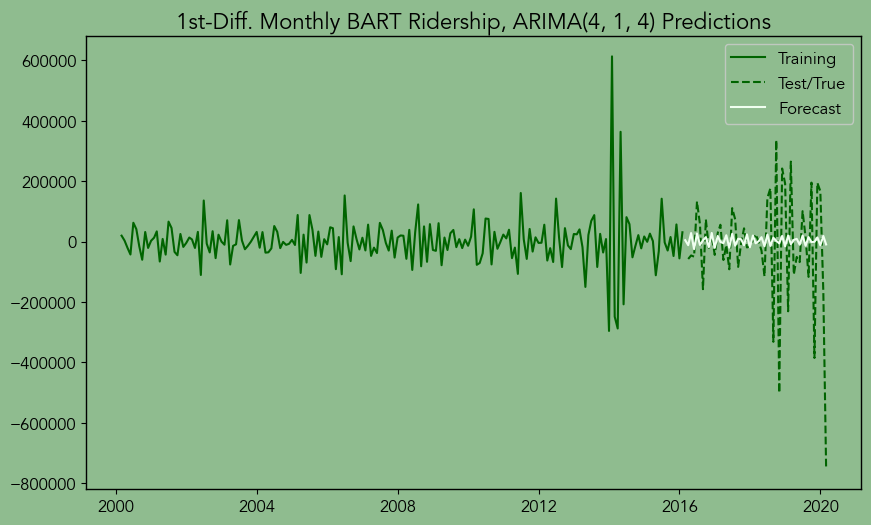

In [19]:
# Plot data.
plt.figure(figsize=(10,6))

plt.plot(y_train.index, 
    pd.DataFrame(y_train).diff(), 
    color = 'darkgreen', 
    label = 'Training')

# Plot testing data.
plt.plot(y_test.index, 
    pd.DataFrame(y_test).diff(), 
    color = 'darkgreen', 
    linestyle = '--', 
    label = 'Test/True')

# Plot predicted test values.
plt.plot(y_test.index, 
    preds, 
    color = 'honeydew', 
    label = 'Forecast')

plt.title(label = '1st-Diff. Monthly BART Ridership, ARIMA(4, 1, 4) Predictions', fontsize=16)
plt.legend()
plt.show();

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math

mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'AIC: {best_aic}')

print (mae, mse, rmse, best_aic)

MAE: 85583.21725406255
MSE: 22604134487.435894
RMSE: 150346.71425553635
AIC: 4666.696005023667
85583.21725406255 22604134487.435894 150346.71425553635 4666.696005023667
